# CORPUS-INFORMED AUTO-TRANSLATOR: VECTOR CREATION NOTEBOOK
Day 3: Converting JSON Corpora into Semantic Vectors
(Create vectors for multiple corpus items)

**Important note! The jina-embeddings-v3 model used here to create vectors is memory-hungry! To avoid memory crashes in the Google Colab environment, enable T4 GPU in Colab (Runtime → Change runtime type)**

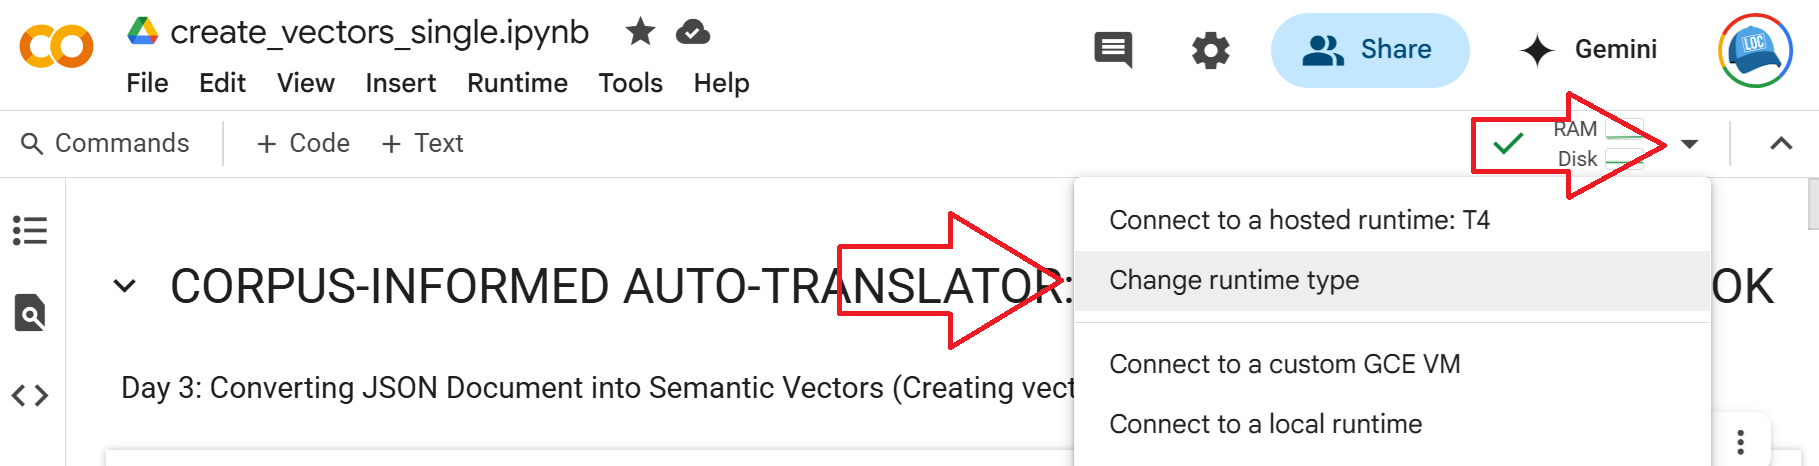

## Notebook Outline

**Part 1: Data Preparation and Planning**

- STEP 1: LOAD THE REQUIRED LIBRARIES
- STEP 2: LOAD AND EXAMINE DATABASE STRUCTURE
- STEP 3: LOAD UNPROCESSED DOCUMENTS FOR BATCH PROCESSING (WITHOUT RE-VECTORIZATION)

**Part 2: Function and Model Setup**

- STEP 4: DEFINE TEXT EXTRACTION FUNCTIONS (FLEXIBLE)
- STEP 5: DEFINE VECTORIZATION FUNCTIONS
- STEP 6: INITIALIZE THE MULTILINGUAL EMBEDDING MODEL

**Part 3: Execution and Output**
- STEP 7: BATCH PROCESS DOCUMENTS
- STEP 8: GENERATE HTML VISUALIZATION REPORT

## =============================================================================

## Universal Environment Setup

In [ ]:
# ==============================================================================
# GOOGLE COLAB SETUP - Run this FIRST!
# ==============================================================================

print("🌍 Setting up Google Colab environment...")

# Install required dependencies
print("📦 Installing dependencies...")
import subprocess
import sys
subprocess.check_call([sys.executable, "-m", "pip", "install", "-q",
                      "sentence-transformers>=2.7.0", "einops>=0.6.0", "ujson>=5.0.0"])
print("✅ Dependencies installed")

# Mount Google Drive
print("🔗 Mounting Google Drive...")
from google.colab import drive
drive.mount('/content/drive')
print("✅ Google Drive mounted")

# Navigate to project folder and setup paths
print("📋 Setting up project paths...")
import os
# Update the 'project_path' to the root level of the project folder on your personal Drive
project_path = '/content/drive/MyDrive/Classroom/Auto-Traductor - UNAM-SMA/Proyectos/pragmatic-auto-translator'
os.chdir(project_path)

# Add scripts to Python path
sys.path.append('./scripts')
print(f"📁 Working directory: {os.getcwd()}")

# Import configuration at module level
print("📋 Loading project configuration...")
try:
    from config import *
    print("✅ Configuration loaded successfully")

    # Display configuration
    print("\n" + "="*60)
    print("🔧 PROJECT CONFIGURATION")
    print("="*60)
    print(f"🎯 Domain: {DOMAIN}")
    print(f"🌐 Languages: {', '.join(LANGUAGES)}")
    print(f"🤖 Model: {MODEL_NAME}")
    print(f"📏 Model dimensions: {MODEL_DIMENSIONS}")
    print(f"📝 Max text length: {MAX_TEXT_LENGTH:,} characters")
    print("="*60)

    setup_success = True

except ImportError as e:
    print(f"❌ Configuration import failed: {e}")
    print("💡 Make sure config.py is in the scripts/ folder")
    setup_success = False

if setup_success:
    print("\n🎯 SETUP COMPLETE - Ready for STEP 1!")
else:
    print("\n❌ Setup failed - check configuration files")

🌍 Environment detected: COLAB
🔄 Setting up Colab environment...
📦 Installing dependencies...
✅ Dependencies installed
🔗 Mounting Google Drive...
Mounted at /content/drive
📁 Navigating to project folder...
📍 Working directory: /content/drive/MyDrive/Classroom/Auto-Traductor - UNAM-SMA/Proyectos/pragmatic-auto-translator
✅ Colab setup complete
📋 Loading configuration...
🌍 Environment detected: COLAB
🔗 Setting up Google Colab environment...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Google Drive mounted
📁 Using project structure: /content/drive/MyDrive/Classroom/Auto-Traductor - UNAM-SMA/Proyectos/pragmatic-auto-translator

🔧 UNAM AUTO-TRADUCTOR CONFIGURATION
Environment: colab
Domain: gai
Languages: eng, esp
Model: jinaai/jina-embeddings-v3
Dimensions: 1024
Corpora directory: /content/drive/MyDrive/Classroom/Auto-Traductor - UNAM-SMA/Proyectos/pragmatic-auto-translator/corpora/gai
Vectors directory: /


## Part 1: Data Preparation and Planning

### STEP 1: LOAD THE REQUIRED LIBRARIES

In [ ]:
# ==============================================================================
# STEP 1: LOAD THE REQUIRED LIBRARIES
# ==============================================================================

print("\n📚 Loading required libraries...")

# Core Python libraries
import os
import json
from pathlib import Path
import logging
from typing import Dict, List, Tuple, Optional
from datetime import datetime

# Data processing libraries
import pandas as pd
import numpy as np

# Text processing libraries
import re
from collections import defaultdict

# Machine learning and embedding libraries
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

# Progress tracking
from tqdm.notebook import tqdm

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

print("✅ All libraries loaded successfully!")

# Verify corpus files exist
print("\n🔍 Verifying corpus database files...")
corpus_files_found = 0
for language in LANGUAGES:
    db_file = f"{CORPORA_DIR}/{language}/{DOMAIN}-{language}_database.json"
    if Path(db_file).exists():
        print(f"✅ Found: {language.upper()} corpus ({Path(db_file).name})")
        corpus_files_found += 1
    else:
        print(f"❌ Missing: {language.upper()} corpus at {db_file}")

if corpus_files_found == len(LANGUAGES):
    print(f"\n🎉 All {len(LANGUAGES)} corpus database files found - ready for vectorization!")
else:
    print(f"\n⚠️ Found {corpus_files_found}/{len(LANGUAGES)} corpus files - check file paths")

print("\n" + "="*60)
print("🚀 READY FOR STEP 2: LOAD AND EXAMINE DATABASE STRUCTURE")
print("="*60)

✅ All libraries loaded successfully!

🔧 CURRENT CONFIGURATION SETTINGS
Domain: gai
Languages: eng, esp
Model: jinaai/jina-embeddings-v3
Model dimensions: 1024
Model task optimization: retrieval.passage
Max text length: 8,000 tokens
Create document vectors: True
Create section vectors: True
Create paragraph vectors: True


### STEP 2: LOAD AND EXAMINE DATABASE STRUCTURE

In [ ]:
# STEP 2: LOAD AND EXAMINE DATABASE STRUCTURE

def load_database_file(language):
    """Load the database file for a specific language"""
    database_path = Path(CORPORA_DIR) / language / f"{DOMAIN}-{language}_database.json"

    if not database_path.exists():
        raise FileNotFoundError(f"Database file not found: {database_path}")

    with open(database_path, 'r', encoding='utf-8') as f:
        return json.load(f)

def extract_documents_from_db(db, language):
    """Extract document data from database, handling different structures"""
    documents = {}

    # Get documents from nested 'documents' key
    if 'documents' in db and isinstance(db['documents'], dict):
        nested_docs = {k: v for k, v in db['documents'].items()
                      if k.startswith(f'{DOMAIN}-{language}_item')}
        documents.update(nested_docs)

    # Also check for direct top-level document keys
    top_level_docs = {k: v for k, v in db.items()
                     if k != f'{DOMAIN}_template' and k != 'documents'
                     and k.startswith(f'{DOMAIN}-{language}_item')}
    documents.update(top_level_docs)

    return documents

# Load databases for all languages
print("🔍 Loading corpus databases...")

databases = {}
all_documents = {}
failed_languages = []

for language in LANGUAGES:
    try:
        databases[language] = load_database_file(language)
        all_documents[language] = extract_documents_from_db(databases[language], language)
        print(f"✅ {language.upper()}: {len(all_documents[language])} documents loaded")

        # Show all document IDs and titles for this language
        if all_documents[language]:
            print(f"   All document IDs:")
            for i, (doc_id, doc_data) in enumerate(all_documents[language].items(), 1):
                title = doc_data.get('document_metadata', {}).get('title', 'No title')
                print(f"     {i:2d}. {doc_id}: {title[:60]}{'...' if len(title) > 60 else ''}")
        print()  # Add blank line between languages

    except FileNotFoundError as e:
        failed_languages.append(language)
        print(f"❌ {language.upper()}: Database not found")

# Show overall results
total_documents = sum(len(docs) for docs in all_documents.values())
print(f"📊 Total: {total_documents} documents across {len(databases)} languages")

# Create summary for easy access by later steps
document_summary = {
    'total_count': total_documents,
    'by_language': {lang: len(docs) for lang, docs in all_documents.items()},
    'all_documents': all_documents
}

print(f"✅ Database loading complete! Ready for vectorization.")

# Only show errors if any occurred
if failed_languages:
    print(f"\n⚠️  Failed to load: {', '.join(failed_languages)}")
    for lang in failed_languages:
        expected_path = Path(CORPORA_DIR) / lang / f"{DOMAIN}-{lang}_database.json"
        print(f"   Expected: {expected_path}")

🔍 Loading corpus databases...
✅ ENG: 4 documents loaded
   All document IDs:
      1. gai-eng_item001: Attention is All You Need
      2. gai-eng_item002: On the Dangers of Stochastic Parrots: Can Language Models Be...
      3. gai-eng_item003: Recommendation on the Ethics of Artificial Intelligence
      4. gai-eng_item004: The Age of AI has begun

✅ ESP: 2 documents loaded
   All document IDs:
      1. gai-esp_item001: Propuesta de Agenda Nacional de la Inteligencia Artificial p...
      2. gai-esp_item002: Conversando con una computadora: ¿Cómo entienden las intelig...

📊 Total: 6 documents across 2 languages
✅ Database loading complete! Ready for vectorization.


### STEP 3: LOAD UNPROCESSED DOCUMENTS FOR BATCH PROCESSING (NO RE-VECTORIZATION)

In [ ]:
# STEP 3: LOAD UNPROCESSED DOCUMENTS FOR BATCH PROCESSING (NO RE-VECTORIZATION)
# Block 1: Helper functions (for use in step 3 and later)

# Change the 'doc_id' below to match the naming conventions for your files
def load_corpus_item(language, doc_id):
    """
    Load both the metadata and content data for a specific document

    Args:
        language: Language code ('eng', 'fra', etc.)
        doc_id: Document ID (e.g., 'gai-eng_item004')

    Returns:
        Dictionary containing both metadata and content
    """
    # Load metadata from database
    if language not in all_documents:
        raise ValueError(f"Language '{language}' not found in loaded databases")

    if doc_id not in all_documents[language]:
        raise ValueError(f"Document '{doc_id}' not found in {language} database")

    metadata = all_documents[language][doc_id]

    # Load content from separate content file
    content_file_path = Path(CORPORA_DIR) / language / 'processed' / f'{doc_id}.json'

    if not content_file_path.exists():
        raise FileNotFoundError(f"Content file not found: {content_file_path}")

    try:
        with open(content_file_path, 'r', encoding='utf-8') as f:
            content_data = json.load(f)
    except Exception as e:
        raise ValueError(f"Error loading content file {content_file_path}: {e}")

    # Merge metadata and content
    merged_data = {
        'document_metadata': metadata.get('document_metadata', {}),
        'processing_metadata': metadata.get('processing_metadata', {}),
        'document_id': content_data.get('document_id', doc_id),
        'content': content_data.get('content', {})
    }

    return merged_data

def get_document_metadata(databases_dict, language, doc_id):
    """
    Extract metadata for a specific document

    Args:
        databases_dict: The databases dictionary (not used but kept for compatibility)
        language: Language code
        doc_id: Document ID

    Returns:
        Document metadata dictionary
    """
    if language not in all_documents:
        raise ValueError(f"Language '{language}' not found in loaded databases")

    if doc_id not in all_documents[language]:
        raise ValueError(f"Document '{doc_id}' not found in {language} database")

    document_data = all_documents[language][doc_id]
    return document_data.get('document_metadata', {})

def merge_content_and_metadata(content_data, metadata):
    """
    Merge document content and metadata into a single structure

    Args:
        content_data: Full document data (already merged from load_corpus_item)
        metadata: Document metadata (usually already part of content_data)

    Returns:
        Merged document structure ready for processing
    """
    # The content_data from load_corpus_item already contains everything we need
    # but we'll ensure metadata is properly merged
    merged = content_data.copy()

    # Ensure document_metadata is present and updated
    if 'document_metadata' not in merged:
        merged['document_metadata'] = {}

    # Update with any additional metadata
    merged['document_metadata'].update(metadata)

    return merged

print("✅ Helper functions loaded and ready to use!")

✅ Helper functions loaded and ready to use!


In [ ]:
# STEP 3: LOAD UNPROCESSED DOCUMENTS FOR BATCH PROCESSING (NO RE-VECTORIZATION)
# Block 2: Isolate unprocessed documents

def load_existing_vector_files_comprehensive(vector_dir=None):
    """
    Comprehensively load all existing vector files and extract processed document IDs
    Returns detailed information about what's already processed
    """
    # Use config-based vector directory if not specified
    if vector_dir is None:
        vector_dir = VECTORS_DIR

    vector_dir = Path(vector_dir)

    processed_info = {
        'document_ids': set(),
        'section_ids': set(),
        'paragraph_ids': set(),
        'files_found': {},
        'total_vectors': 0
    }

    # Define the three vector files we expect; update these to match your file naming instructions
    vector_files = {
        'documents': 'gai-document-vectors.json',
        'sections': 'gai-section-vectors.json',
        'paragraphs': 'gai-paragraph-vectors.json'
    }

    print(f"🔍 CHECKING EXISTING VECTORS IN: {vector_dir}")

    for vector_type, filename in vector_files.items():
        filepath = vector_dir / filename

        if filepath.exists():
            try:
                with open(filepath, 'r', encoding='utf-8') as f:
                    data = json.load(f)

                # Handle both new schema and legacy formats
                vectors = data.get('vectors', data.get('vector_data', []))

                processed_info['files_found'][vector_type] = {
                    'path': str(filepath),
                    'count': len(vectors),
                    'size_mb': filepath.stat().st_size / (1024*1024)
                }

                # Extract IDs based on vector type
                if vector_type == 'documents':
                    for vector in vectors:
                        processed_info['document_ids'].add(vector.get('id', ''))
                elif vector_type == 'sections':
                    for vector in vectors:
                        processed_info['section_ids'].add(vector.get('id', ''))
                        # Also track the parent document
                        doc_id = vector.get('document_id', '')
                        if doc_id:
                            processed_info['document_ids'].add(doc_id)
                elif vector_type == 'paragraphs':
                    for vector in vectors:
                        processed_info['paragraph_ids'].add(vector.get('id', ''))
                        # Also track the parent document
                        doc_id = vector.get('document_id', '')
                        if doc_id:
                            processed_info['document_ids'].add(doc_id)

                processed_info['total_vectors'] += len(vectors)

                print(f"  ✅ {vector_type.title()}: {len(vectors)} vectors found")

            except Exception as e:
                print(f"  ❌ Error reading {filepath}: {e}")
                processed_info['files_found'][vector_type] = {'error': str(e)}
        else:
            print(f"  📝 {vector_type.title()}: No existing file found")
            processed_info['files_found'][vector_type] = {'status': 'not_found'}

    # Remove empty strings from sets
    processed_info['document_ids'].discard('')
    processed_info['section_ids'].discard('')
    processed_info['paragraph_ids'].discard('')

    print(f"\n📊 EXISTING VECTORS SUMMARY:")
    print(f"  • Unique documents with vectors: {len(processed_info['document_ids'])}")
    print(f"  • Total sections: {len(processed_info['section_ids'])}")
    print(f"  • Total paragraphs: {len(processed_info['paragraph_ids'])}")
    print(f"  • Grand total vectors: {processed_info['total_vectors']}")

    return processed_info

def find_truly_unprocessed_documents(all_documents, processed_info):
    """
    Find documents that have NO vectors at all (completely unprocessed)
    More robust than just checking document-level vectors
    """
    unprocessed = []
    processed_doc_ids = processed_info['document_ids']

    print(f"\n🔍 IDENTIFYING UNPROCESSED DOCUMENTS:")

    for language, docs in all_documents.items():
        for doc_id, doc_data in docs.items():
            if doc_id not in processed_doc_ids:
                # Get document info
                doc_metadata = doc_data.get('document_metadata', {})
                processing_metadata = doc_data.get('processing_metadata', {})

                unprocessed.append({
                    'document_id': doc_id,
                    'language': language,
                    'title': doc_metadata.get('title', 'No title'),
                    'text_type': doc_metadata.get('text_type', 'Unknown'),
                    'word_count': processing_metadata.get('word_count', 0),
                    'language_family': doc_metadata.get('language_family', 'unknown'),
                    'language_variant': doc_metadata.get('language_variant', 'unknown')
                })

                print(f"  📄 {doc_id} - Not processed")
            else:
                print(f"  ✅ {doc_id} - Already processed")

    return unprocessed

def load_documents_for_batch(documents_to_process):
    """
    Load the actual document content for processing
    Uses your existing load_corpus_item() helper function
    """
    loaded_documents = []

    print(f"\n📖 LOADING DOCUMENT CONTENT:")

    for doc_info in documents_to_process:
        doc_id = doc_info['document_id']
        language = doc_info['language']

        print(f"  Loading {doc_id}...")

        try:
            # Use your existing helper function
            document = load_corpus_item(language, doc_id)

            # Add the processing info
            document['processing_info'] = doc_info

            loaded_documents.append(document)
            print(f"    ✅ Success")

        except Exception as e:
            print(f"    ❌ Error: {e}")

    return loaded_documents

# Run the comprehensive check
existing_vectors_info = load_existing_vector_files_comprehensive()

# Find unprocessed documents using the comprehensive info
documents_to_process = find_truly_unprocessed_documents(all_documents, existing_vectors_info)

print(f"\n📊 FINAL PROCESSING STATUS:")
print(f"  • Total documents in database: {sum(len(docs) for docs in all_documents.values())}")
print(f"  • Documents with existing vectors: {len(existing_vectors_info['document_ids'])}")
print(f"  • Documents needing processing: {len(documents_to_process)}")

if documents_to_process:
    print(f"\n📝 DOCUMENTS TO PROCESS ({len(documents_to_process)} total):")
    for i, doc in enumerate(documents_to_process, 1):
        print(f"  {i:2d}. {doc['document_id']} ({doc['language'].upper()})")
        print(f"      {doc['title'][:50]}{'...' if len(doc['title']) > 50 else ''}")
        print(f"      Type: {doc['text_type']} | Words: {doc['word_count']:,}")

    # Load the documents for processing
    loaded_docs = load_documents_for_batch(documents_to_process)

    print(f"\n✅ LOADING COMPLETE:")
    print(f"  📦 Successfully loaded: {len(loaded_docs)} documents")

    if len(loaded_docs) != len(documents_to_process):
        print(f"  ⚠️  Failed to load: {len(documents_to_process) - len(loaded_docs)} documents")
else:
    print(f"\n🎉 ALL DOCUMENTS ALREADY PROCESSED!")
    print(f"    No new vectorization needed.")
    loaded_docs = []

print(f"\n✅ STEP 3 COMPLETE - Ready for vectorization functions in STEP 5!")

🔍 CHECKING EXISTING VECTORS IN: /content/drive/MyDrive/Classroom/Auto-Traductor - UNAM-SMA/Proyectos/pragmatic-auto-translator/vectors/gai
  ✅ Documents: 1 vectors found
  ✅ Sections: 22 vectors found
  ✅ Paragraphs: 70 vectors found

📊 EXISTING VECTORS SUMMARY:
  • Unique documents with vectors: 1
  • Total sections: 22
  • Total paragraphs: 70
  • Grand total vectors: 93

🔍 IDENTIFYING UNPROCESSED DOCUMENTS:
  ✅ gai-eng_item001 - Already processed
  📄 gai-eng_item002 - Not processed
  📄 gai-eng_item003 - Not processed
  📄 gai-eng_item004 - Not processed
  📄 gai-esp_item001 - Not processed
  📄 gai-esp_item002 - Not processed

📊 FINAL PROCESSING STATUS:
  • Total documents in database: 6
  • Documents with existing vectors: 1
  • Documents needing processing: 5

📝 DOCUMENTS TO PROCESS (5 total):
   1. gai-eng_item002 (ENG)
      On the Dangers of Stochastic Parrots: Can Language...
      Type: Academic paper | Words: 15,544
   2. gai-eng_item003 (ENG)
      Recommendation on the Ethics

## =============================================================================

## Part 2: Function and Model Setup

### STEP 4: FLEXIBLE TEXT EXTRACTION FUNCTIONS

In [ ]:
# STEP 4: FLEXIBLE TEXT EXTRACTION FUNCTIONS
# Block 1: Extract text

# COMPREHENSIVE EXTRACTION FUNCTIONS

def extract_text_from_any_element(element, element_type="text"):
    """
    Flexible text extraction from any element type

    Handles:
    - Regular text fields
    - Terms with definitions
    - Figures with captions
    - Lists with items
    - References
    - Citations with various formats
    """
    if isinstance(element, dict):
        # Handle different element types
        if element_type == "term":
            term = element.get('term', '')
            definition = element.get('definition', '')
            return f"{term}: {definition}"

        elif element_type == "figure":
            caption = element.get('caption', '')
            description = element.get('description', '')
            # Handle figures that have paragraphs
            paragraph_texts = []
            if 'paragraphs' in element:
                for para in element.get('paragraphs', []):
                    para_text = extract_text_from_any_element(para)
                    if para_text:
                        paragraph_texts.append(para_text)

            all_texts = [caption, description] + paragraph_texts
            return ' '.join([t for t in all_texts if t])

        elif element_type == "reference":
            return element.get('text', '')

        elif element_type == "citation":
            # Handle both reference_id (string) and reference_ids (array)
            marker = element.get('marker', '')
            if 'reference_id' in element:
                ref_id = element.get('reference_id')
                if isinstance(ref_id, list):
                    return f"[{marker}: {', '.join(ref_id)}]"
                else:
                    return f"[{marker}: {ref_id}]"
            elif 'reference_ids' in element:
                ref_ids = element.get('reference_ids', [])
                if ref_ids:  # Check if not empty
                    return f"[{marker}: {', '.join(ref_ids)}]"
                else:
                    return f"[{marker}]"

        else:
            # Default: try to get 'text' field
            return element.get('text', '')

    elif isinstance(element, str):
        return element

    return ""

def extract_paragraph_text_flexible(paragraph):
    """
    Extract text from a paragraph, handling various embedded elements
    """
    if not isinstance(paragraph, dict):
        return "", ""

    paragraph_id = paragraph.get('id', 'unknown')
    texts = []

    # Main paragraph text
    main_text = paragraph.get('text', '')
    if main_text:
        texts.append(main_text)

    # Handle lists (like in journal articles)
    if 'list' in paragraph:
        for item in paragraph.get('list', []):
            item_text = extract_text_from_any_element(item)
            if item_text:
                texts.append(f"• {item_text}")

    # Handle footnotes
    if 'footnotes' in paragraph:
        for footnote in paragraph.get('footnotes', []):
            marker = footnote.get('marker', '')
            text = footnote.get('text', '')
            texts.append(f"[Footnote {marker}]: {text}")

    # Handle citations
    if 'citations' in paragraph:
        citation_texts = []
        for citation in paragraph.get('citations', []):
            cite_text = extract_text_from_any_element(citation, 'citation')
            if cite_text:
                citation_texts.append(cite_text)
        if citation_texts:
            texts.append(f"Citations: {' '.join(citation_texts)}")

    # Handle external links (Built in for gai-eng_item004 structure)
    if 'external_links' in paragraph:
        link_texts = []
        for link in paragraph.get('external_links', []):
            marker = link.get('marker', '')
            url = link.get('url', '')
            if marker and url:
                link_texts.append(f"[Link: {marker} -> {url}]")
            elif marker:
                link_texts.append(f"[Link: {marker}]")
        if link_texts:
            texts.append(f"External links: {' '.join(link_texts)}")

    # Handle inline equations
    if 'inline_equations' in paragraph:
        for eq in paragraph.get('inline_equations', []):
            eq_text = eq.get('text', '')
            if eq_text:
                texts.append(f"[Equation: {eq_text}]")

    # Handle internal references
    if 'internal_references' in paragraph:
        for ref in paragraph.get('internal_references', []):
            ref_text = ref.get('text', '')
            # Handle both field name variations
            target = ref.get('target_section_id', ref.get('target_id', ''))
            if ref_text:
                texts.append(f"[Ref: {ref_text} -> {target}]")

    # Handle any embedded paragraphs (for complex structures)
    if 'paragraphs' in paragraph:
        for sub_para in paragraph.get('paragraphs', []):
            _, sub_text = extract_paragraph_text_flexible(sub_para)
            if sub_text:
                texts.append(sub_text)

    # Combine all text
    full_text = ' '.join(texts)

    # Clean text
    full_text = extract_clean_text(full_text)

    return paragraph_id, full_text

def extract_section_content_flexible(section, parent_id="", level=0, corpus_item=None):
    """
    Flexibly extract content from sections with various structures
    """

    section_id = section.get('id', 'unknown')
    # Handle both 'title' and 'group' fields
    section_title = section.get('title', section.get('group', ''))
    section_type = section.get('type', 'standard')  # For special section types

    # Get document_id from corpus_item
    document_id = 'unknown'
    if corpus_item:
        document_id = corpus_item.get('document_id', 'unknown')

    # Build section ID
    if level == 0:
        full_section_id = section_id
    else:
        full_section_id = f"{parent_id}_{section_id.split('_')[-1]}"

    section_texts = []
    all_paragraphs = []
    subsection_results = []
    special_content = {}

    # Add section title if present
    if section_title:
        section_texts.append(section_title)

    # Extract paragraphs
    for paragraph in section.get('paragraphs', []):
        para_id, para_text = extract_paragraph_text_flexible(paragraph)
        if para_text:
            section_texts.append(para_text)
            all_paragraphs.append({
                'id': para_id,
                'text': para_text,
                'section_id': full_section_id,
                'section_title': section_title,
                'document_id': document_id,
                'level': level
            })

    # Handle terms (for glossaries)
    if 'terms' in section:
        special_content['terms'] = []
        for term in section.get('terms', []):
            term_text = extract_text_from_any_element(term, 'term')
            if term_text:
                section_texts.append(term_text)
                special_content['terms'].append({
                    'id': term.get('id', ''),
                    'text': term_text
                })

    # Handle references
    if 'references' in section:
        special_content['references'] = []
        for ref in section.get('references', []):
            ref_text = extract_text_from_any_element(ref, 'reference')
            if ref_text:
                section_texts.append(ref_text)
                special_content['references'].append({
                    'id': ref.get('id', ''),
                    'text': ref_text
                })

    # Handle figures
    if 'figures' in section:
        special_content['figures'] = []
        for figure in section.get('figures', []):
            fig_text = extract_text_from_any_element(figure, 'figure')
            if fig_text:
                section_texts.append(fig_text)
                special_content['figures'].append({
                    'id': figure.get('id', ''),
                    'text': fig_text
                })

    # Handle tables
    if 'tables' in section:
        special_content['tables'] = []
        for table in section.get('tables', []):
            caption = table.get('caption', '')
            if caption:
                section_texts.append(f"Table: {caption}")
                special_content['tables'].append({
                    'id': table.get('id', ''),
                    'caption': caption
                })

    # Process subsections recursively
    for subsection in section.get('subsections', []):
        subsection_content = extract_section_content_flexible(
            subsection,
            full_section_id,
            level + 1,
            corpus_item
        )
        subsection_results.append(subsection_content)
        section_texts.append(subsection_content['section_text'])
        all_paragraphs.extend(subsection_content['all_paragraphs'])

    # Process subsubsections (for deeper nesting)
    for subsubsection in section.get('subsubsections', []):
        subsubsection_content = extract_section_content_flexible(
            subsubsection,
            full_section_id,
            level + 1,
            corpus_item
        )
        subsection_results.append(subsubsection_content)
        section_texts.append(subsubsection_content['section_text'])
        all_paragraphs.extend(subsubsection_content['all_paragraphs'])

    # Combine all text
    combined_section_text = ' '.join(section_texts)

    return {
        'section_id': full_section_id,
        'section_title': section_title,
        'section_type': section_type,
        'section_text': combined_section_text,
        'document_id': document_id,
        'subsections': subsection_results,
        'all_paragraphs': all_paragraphs,
        'special_content': special_content,
        'level': level
    }

def extract_document_content_flexible(corpus_item):
    """
    Extract all content from a document with flexible structure
    """
    print(f"📄 Extracting content from: {corpus_item.get('document_id', 'Unknown')}")

    document_texts = []
    all_sections = []
    all_paragraphs = []
    special_elements = {
        'figures': [],
        'tables': [],
        'equations': [],
        'pull_quotes': [],
        'external_links': [],
        'terms': [],
        'references': []
    }

    # Extract metadata
    metadata = corpus_item.get('document_metadata', {})
    doc_id = corpus_item.get('document_id', 'unknown')
    title = metadata.get('title', '')
    language_family = metadata.get('language_family', 'unknown')
    language_variant = metadata.get('language_variant', 'unknown')
    language = f"{language_family}-{language_variant}"
    text_type = metadata.get('text_type', 'unknown')

    # Add title
    if title:
        document_texts.append(title)

    # Extract content
    content = corpus_item.get('content', {})

    # Check for abstract (not all documents have this)
    abstract = content.get('abstract', '')
    if abstract:
        clean_abstract = extract_clean_text(abstract)
        document_texts.append(clean_abstract)
        all_paragraphs.append({
            'id': f"{doc_id}_abstract",
            'text': clean_abstract,
            'section_id': 'abstract',
            'section_title': 'Abstract',
            'document_id': doc_id,
            'level': -1
        })

    # Process all sections
    for section in content.get('sections', []):
        section_content = extract_section_content_flexible(
            section,
            "",
            0,
            corpus_item
        )

        # Add to document text
        document_texts.append(section_content['section_text'])

        # Collect all sections
        def collect_sections(section_data):
            all_sections.append({
                'id': section_data['section_id'],
                'title': section_data['section_title'],
                'type': section_data['section_type'],
                'text': section_data['section_text'],
                'document_id': section_data['document_id'],
                'level': section_data['level']
            })

            # Collect special content
            for content_type, items in section_data['special_content'].items():
                if items:
                    special_elements[content_type].extend(items)

            for subsection in section_data['subsections']:
                collect_sections(subsection)

        collect_sections(section_content)
        all_paragraphs.extend(section_content['all_paragraphs'])

    # Extract top-level figures (if present)
    for figure in content.get('figures', []):
        fig_text = extract_text_from_any_element(figure, 'figure')
        if fig_text:
            special_elements['figures'].append({
                'id': figure.get('id', ''),
                'text': fig_text
            })
            document_texts.append(fig_text)

    # Extract top-level tables (if present)
    for table in content.get('tables', []):
        caption = table.get('caption', '')
        if caption:
            special_elements['tables'].append({
                'id': table.get('id', ''),
                'caption': caption
            })
            document_texts.append(f"Table: {caption}")

    # Extract top-level equations (if present)
    for equation in content.get('equations', []):
        eq_id = equation.get('id', '')
        latex = equation.get('latex', '')
        if latex:
            special_elements['equations'].append({
                'id': eq_id,
                'latex': latex
            })
            document_texts.append(f"Equation {eq_id}: {latex}")

    # Extract top-level references (if present)
    for reference in content.get('references', []):
        ref_text = reference.get('text', '')
        if ref_text:
            special_elements['references'].append({
                'id': reference.get('id', ''),
                'text': ref_text
            })
            document_texts.append(ref_text)

    # Extract pull quotes (if present)
    for quote in content.get('pull_quotes', []):
        quote_text = quote.get('text', '')
        if quote_text:
            special_elements['pull_quotes'].append({
                'id': quote.get('id', ''),
                'text': quote_text
            })

    # Combine all text
    full_document_text = ' '.join(document_texts)

    # Calculate statistics
    stats = {
        'total_sections': len(all_sections),
        'total_paragraphs': len(all_paragraphs),
        'document_length': len(full_document_text),
        'text_type': text_type,
        'has_abstract': bool(abstract),
        'has_figures': len(special_elements['figures']) > 0,
        'has_tables': len(special_elements['tables']) > 0,
        'has_equations': len(special_elements['equations']) > 0,
        'has_terms': len(special_elements['terms']) > 0,
        'has_references': len(special_elements['references']) > 0,
        'has_pull_quotes': len(special_elements['pull_quotes']) > 0
    }

    print(f"  ✅ Extracted: {stats['total_sections']} sections, {stats['total_paragraphs']} paragraphs")
    print(f"  📊 Document type: {text_type}")
    print(f"  🎯 Special elements: " + ', '.join([k for k, v in special_elements.items() if v]))

    return {
        'document_id': doc_id,
        'title': title,
        'language': language,
        'text_type': text_type,
        'document_text': full_document_text,
        'sections': all_sections,
        'paragraphs': all_paragraphs,
        'special_elements': special_elements,
        'statistics': stats
    }

# Helper function to clean text (assuming you have this)
def extract_clean_text(text):
    """
    Clean text by removing extra whitespaces, normalizing quotes, etc.
    """
    if not text:
        return ""

    # Replace multiple spaces with single space
    text = ' '.join(text.split())

    # Normalize quotes
    text = text.replace('"', '"').replace('"', '"')
    text = text.replace(''', "'").replace(''', "'")

    # Remove leading/trailing whitespace
    text = text.strip()

    return text

print("✅ Flexible extraction functions defined and ready to use!")

✅ Flexible extraction functions defined and ready to use!


Potential Minor Improvements for future iterations:

- equation_numbers arrays in paragraphs that the current code doesn’t explicitly handle
- external_links in some paragraphs that aren’t currently extracted
- The  current code also only extracts table captions, not the full table content (rows/columns)

In [ ]:
# STEP 4: FLEXIBLE TEXT EXTRACTION FUNCTIONS
# Block 2: Test and verify extraction of one document

# Note: Update this section to text extraction of a document of your choosing

def verify_extraction_details(extracted_data, show_full_text=False):
    """
    Print detailed information about what was extracted from the document
    """
    print(f"\n🔍 DETAILED EXTRACTION VERIFICATION")
    print(f"=" * 60)

    # Basic stats
    print(f"📋 Document ID: {extracted_data['document_id']}")
    print(f"📑 Title: {extracted_data['title']}")
    print(f"🌐 Language: {extracted_data['language']}")
    print(f"📄 Text type: {extracted_data['text_type']}")

    # Section details
    print(f"\n📚 SECTIONS EXTRACTED ({len(extracted_data['sections'])} total):")
    for i, section in enumerate(extracted_data['sections'], 1):
        print(f"  {i}. [{section['id']}] {section['title']}")
        if section['type'] != 'standard':
            print(f"     (Type: {section['type']})")

    # Paragraph details
    print(f"\n📝 PARAGRAPHS EXTRACTED ({len(extracted_data['paragraphs'])} total):")
    for i, para in enumerate(extracted_data['paragraphs'][:5], 1):  # Show first 5
        print(f"  {i}. [{para['id']}] in section '{para['section_title']}'")
        # Show first 100 characters of paragraph text
        preview = para['text'][:100] + "..." if len(para['text']) > 100 else para['text']
        print(f"     Text: {preview}")

    if len(extracted_data['paragraphs']) > 5:
        print(f"     ... and {len(extracted_data['paragraphs']) - 5} more paragraphs")

    # Special elements details
    print(f"\n🎯 SPECIAL ELEMENTS FOUND:")
    for element_type, items in extracted_data['special_elements'].items():
        if items:
            print(f"  • {element_type.title()}: {len(items)} found")
            # Show details for some types
            if element_type == 'pull_quotes' and items:
                for quote in items:
                    print(f"    - \"{quote['text'][:80]}...\"")
            elif element_type == 'figures' and items:
                for fig in items[:3]:  # Show first 3
                    print(f"    - [{fig['id']}]: {fig['text'][:60]}...")

    # Document text preview
    print(f"\n📄 DOCUMENT TEXT PREVIEW:")
    print(f"  Total length: {len(extracted_data['document_text']):,} characters")
    if show_full_text:
        print(f"  Full text:\n{extracted_data['document_text']}")
    else:
        # Show first 300 characters
        preview = extracted_data['document_text'][:300] + "..." if len(extracted_data['document_text']) > 300 else extracted_data['document_text']
        print(f"  First 300 chars: {preview}")

    # Statistics summary
    stats = extracted_data['statistics']
    print(f"\n📊 STATISTICS:")
    print(f"  • Total sections: {stats['total_sections']}")
    print(f"  • Total paragraphs: {stats['total_paragraphs']}")
    print(f"  • Document length: {stats['document_length']:,} characters")
    print(f"  • Has abstract: {stats['has_abstract']}")
    print(f"  • Has figures: {stats['has_figures']}")
    print(f"  • Has tables: {stats['has_tables']}")
    print(f"  • Has equations: {stats['has_equations']}")
    print(f"  • Has pull quotes: {stats['has_pull_quotes']}")

    return True

# Test specifically with the gai-eng_item004 document
def test_gai_eng_item004():
    """
    Test the extraction with the specific document structure
    """
    print(f"\n🧪 TESTING gai-eng_item004 EXTRACTION")
    print(f"=" * 60)

    try:
        # Load the document (adjust path as needed)
        doc_id = "gai-eng_item004"
        lang = "eng"

        # Load content and metadata
        content_data = load_corpus_item(lang, doc_id)
        metadata = get_document_metadata(databases, lang, doc_id)
        corpus_item = merge_content_and_metadata(content_data, metadata)

        # Extract with flexible function
        extracted = extract_document_content_flexible(corpus_item)

        # Show detailed verification
        verify_extraction_details(extracted, show_full_text=False)

        # Specific checks for this document
        print(f"\n✅ SPECIFIC CHECKS FOR gai-eng_item004:")
        # Replace the number 7 with the expected number of sections/subsections/subsubsections in your document
        print(f"  • Expected 7 sections: {'✓' if len(extracted['sections']) == 7 else '✗'} (found {len(extracted['sections'])})")

        # Store result globally for further use
        global test_result
        test_result = extracted

        return extracted

    except Exception as e:
        print(f"  ❌ Error during extraction: {e}")
        import traceback
        traceback.print_exc()
        return None

# Run the test
print("🚀 Running extraction test...")
result = test_gai_eng_item004()

# Show section titles to verify all expected sections are there
if result:
    print(f"\n📚 ALL SECTION TITLES FOUND:")
    for i, section in enumerate(result['sections'], 1):
        print(f"  {i}. {section['title']}")

    print(f"\n💾 Result stored in 'test_result' variable for further use")
else:
    print(f"\n❌ Test failed - check the error messages above")

🚀 Running extraction test...

🧪 TESTING gai-eng_item004 EXTRACTION
📄 Extracting content from: gai-eng_item004
  ✅ Extracted: 7 sections, 56 paragraphs
  📊 Document type: Blog post
  🎯 Special elements: pull_quotes

🔍 DETAILED EXTRACTION VERIFICATION
📋 Document ID: gai-eng_item004
📑 Title: The Age of AI has begun
🌐 Language: eng-usa
📄 Text type: Blog post

📚 SECTIONS EXTRACTED (7 total):
  1. [section_1] Introduction
  2. [section_2] Defining artificial intelligence
  3. [section_3] Productivity enhancement
  4. [section_4] Health
  5. [section_5] Education
  6. [section_6] Risks and problems with AI
  7. [section_7] The next frontiers

📝 PARAGRAPHS EXTRACTED (56 total):
  1. [p1_1] in section 'Introduction'
     Text: In my lifetime, I’ve seen two demonstrations of technology that struck me as revolutionary.
  2. [p1_2] in section 'Introduction'
     Text: The first time was in 1980, when I was introduced to a graphical user interface—the forerunner of ev...
  3. [p1_3] in section 'Int

### STEP 5: DEFINE VECTORIZATION FUNCTIONS

In [ ]:
# STEP 5: DEFINE VECTORIZATION FUNCTIONS (SCHEMA-COMPLIANT)
# Block 1: Create vectors

def create_schema_compliant_metadata(model):
    """Create metadata section matching the standardized schema with jina-v3"""
    return {
        "model": MODEL_NAME,  # Uses jinaai/jina-embeddings-v3 from config
        "dimension": MODEL_DIMENSIONS,  # 1024 for jina-v3
        "task": MODEL_TASK,  # retrieval.passage optimization
        "normalization": True,  # jina-v3 uses normalized embeddings
        "created": datetime.now().isoformat(),
        "model_parameters": {
            "trust_remote_code": True,
            "normalize_embeddings": True
        }
    }

def create_document_vector_schema_compliant(extracted_content, model):
    """
    Create a single document-level vector matching existing schema with jina-v3
    """
    # Use jina-v3 optimized encoding
    doc_vector = model.encode(
        extracted_content['document_text'],
        task=MODEL_TASK,
        normalize_embeddings=True
    )

    return {
        'id': extracted_content['document_id'],
        'title': extracted_content['title'],
        'text': extracted_content['document_text'],  # Full text, no truncation
        'vector': doc_vector.tolist()  # Convert numpy array to list for JSON
    }

def create_section_vectors_schema_compliant(extracted_content, model):
    """
    Create vectors for all sections matching existing schema with jina-v3
    """
    section_vectors = []

    for section in extracted_content['sections']:
        if section['text'].strip():  # Only create vectors for non-empty sections
            # Use jina-v3 optimized encoding
            vector = model.encode(
                section['text'],
                task=MODEL_TASK,
                normalize_embeddings=True
            )

            section_vectors.append({
                'id': section['id'],
                'document_id': section['document_id'],
                'title': section['title'],
                'level': section['level'],
                'text': section['text'],  # Full text, no truncation
                'vector': vector.tolist()  # Convert to list for JSON
            })

    return section_vectors

def create_paragraph_vectors_schema_compliant(extracted_content, model):
    """
    Create vectors for all paragraphs matching existing schema with jina-v3
    """
    paragraph_vectors = []

    for paragraph in extracted_content['paragraphs']:
        if paragraph['text'].strip():  # Only create vectors for non-empty paragraphs
            # Use jina-v3 optimized encoding
            vector = model.encode(
                paragraph['text'],
                task=MODEL_TASK,
                normalize_embeddings=True
            )

            paragraph_vectors.append({
                'id': paragraph['id'],
                'document_id': paragraph['document_id'],
                'text': paragraph['text'],  # Full text, no truncation
                'vector': vector.tolist()  # Convert to list for JSON
            })

    return paragraph_vectors

def append_vectors_to_schema_file(new_vectors, vector_type, model, output_dir=None):
    """
    Append new vectors to existing schema-compliant files with jina-v3 metadata
    Creates files if they don't exist, ensures proper count/created fields

    Args:
        new_vectors: List of new vector objects to append
        vector_type: 'document', 'section', or 'paragraph'
        model: SentenceTransformer model for metadata
        output_dir: Output directory path (uses VECTORS_DIR from config if None)

    Returns:
        Dictionary with file info and statistics
    """
    # Use config-based directory if not specified
    if output_dir is None:
        output_dir = VECTORS_DIR

    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)

    # Define filename based on type
    filename_map = {
        'document': f'{DOMAIN}-document-vectors.json',
        'section': f'{DOMAIN}-section-vectors.json',
        'paragraph': f'{DOMAIN}-paragraph-vectors.json'
    }

    if vector_type not in filename_map:
        raise ValueError(f"Invalid vector_type: {vector_type}")

    filepath = output_dir / filename_map[vector_type]

    # Load existing file or create new structure
    if filepath.exists():
        try:
            with open(filepath, 'r', encoding='utf-8') as f:
                existing_data = json.load(f)
        except Exception as e:
            print(f"  ⚠️ Error reading existing file, creating new: {e}")
            existing_data = {"metadata": {}, "vectors": []}
    else:
        existing_data = {"metadata": {}, "vectors": []}

    # Ensure proper structure
    if 'vectors' not in existing_data:
        existing_data['vectors'] = []
    if 'metadata' not in existing_data:
        existing_data['metadata'] = {}

    # Add new vectors with proper count numbering and created timestamps
    current_count = len(existing_data['vectors'])
    timestamp = datetime.now().isoformat()

    for i, vector in enumerate(new_vectors):
        # Create schema-compliant vector object
        vector_with_schema = {
            'id': vector['id'],
            'count': current_count + i + 1,  # REQUIRED: Sequential count
            'created': timestamp,  # REQUIRED: Creation timestamp
            'text': vector['text'],  # REQUIRED: Full text, no truncation
            'vector': vector['vector']  # REQUIRED: Vector array (1024-dim for jina-v3)
        }

        # Add type-specific fields
        if vector_type == 'document':
            vector_with_schema['title'] = vector.get('title', 'No title')
        elif vector_type == 'section':
            vector_with_schema['document_id'] = vector['document_id']
            vector_with_schema['title'] = vector.get('title', 'No title')
            vector_with_schema['level'] = vector.get('level', 0)
        elif vector_type == 'paragraph':
            vector_with_schema['document_id'] = vector['document_id']

        existing_data['vectors'].append(vector_with_schema)

    # Update metadata with jina-v3 info
    existing_data['metadata'] = create_schema_compliant_metadata(model)

    # Save file
    with open(filepath, 'w', encoding='utf-8') as f:
        json.dump(existing_data, f, ensure_ascii=False, indent=2)

    return {
        'file': str(filepath),
        'new_count': len(new_vectors),
        'total_count': len(existing_data['vectors']),
        'size_mb': filepath.stat().st_size / (1024*1024)
    }

print("📋 Functions available:")
print("  • batch_process_and_append_vectors() - Process and append new documents")
print(f"📁 Vector files will be saved to: {VECTORS_DIR}")
print(f"📝 Filenames: {DOMAIN}-document-vectors.json, {DOMAIN}-section-vectors.json, {DOMAIN}-paragraph-vectors.json")

📋 Functions available:
  • batch_process_and_append_vectors() - Process and append new documents


In [ ]:
# STEP 5: DEFINE VECTORIZATION FUNCTIONS (SCHEMA-COMPLIANT)
# Block 2: Verify schema

def verify_jina_v3_schema_consistency(vector_dir=None):
    """
    Verify that all vector files follow the jina-v3 schema from single document processing
    """
    # Use config directory if not specified
    if vector_dir is None:
        vector_dir = VECTORS_DIR

    vector_dir = Path(vector_dir)

    vector_files = [
        (f'{DOMAIN}-document-vectors.json', 'document'),
        (f'{DOMAIN}-section-vectors.json', 'section'),
        (f'{DOMAIN}-paragraph-vectors.json', 'paragraph')
    ]

    all_good = True

    print("🔍 VERIFYING JINA-V3 SCHEMA CONSISTENCY")
    print("=" * 40)

    for filename, vector_type in vector_files:
        filepath = vector_dir / filename

        if filepath.exists():
            try:
                with open(filepath, 'r', encoding='utf-8') as f:
                    data = json.load(f)

                # Check metadata
                metadata = data.get('metadata', {})
                model_name = metadata.get('model', '')
                dimension = metadata.get('dimension', 0)
                task = metadata.get('task', '')
                normalization = metadata.get('normalization', False)
                environment = metadata.get('environment', 'unknown')

                print(f"📄 {filename}:")
                print(f"   Model: {model_name}")
                print(f"   Dimension: {dimension}")
                print(f"   Task: {task}")
                print(f"   Normalized: {normalization}")
                print(f"   Environment: {environment}")

                # Verify jina-v3 specific values
                if model_name != MODEL_NAME:
                    print(f"   ⚠️  Expected model: {MODEL_NAME}")
                if dimension != MODEL_DIMENSIONS:
                    print(f"   ⚠️  Expected dimension: {MODEL_DIMENSIONS}")
                if task != MODEL_TASK:
                    print(f"   ⚠️  Expected task: {MODEL_TASK}")

                # Check required fields in vectors
                vectors = data.get('vectors', [])
                if vectors:
                    first_vector = vectors[0]
                    required_fields = ['id', 'count', 'created', 'text', 'vector']

                    missing_fields = [f for f in required_fields if f not in first_vector]
                    if missing_fields:
                        print(f"   ❌ Missing fields: {missing_fields}")
                        all_good = False
                    else:
                        print(f"   ✅ Schema complete")

                        # Check vector dimension
                        if len(first_vector['vector']) != MODEL_DIMENSIONS:
                            print(f"   ⚠️  Vector dimension mismatch: {len(first_vector['vector'])} != {MODEL_DIMENSIONS}")
                            all_good = False
                        else:
                            print(f"   ✅ Vector dimension: {len(first_vector['vector'])}")

                print(f"   📊 Total vectors: {len(vectors)}")

            except Exception as e:
                print(f"   ❌ Error: {e}")
                all_good = False
        else:
            print(f"📄 {filename}: Not found")

        print()

    if all_good:
        print("✅ All files match jina-v3 schema!")
    else:
        print("⚠️  Some schema inconsistencies found")

    return all_good

print("📋 JINA-V3 FUNCTIONS AVAILABLE:")
print("  • create_schema_compliant_metadata() - Enhanced metadata with jina-v3 info")
print("  • batch_process_and_append_vectors() - Process and append with jina-v3")
print("  • verify_jina_v3_schema_consistency() - Verify jina-v3 schema compliance")
print("💡 All functions use normalized 1024-dimensional embeddings")
print("🎯 Optimized for retrieval.passage task")
print("✅ JINA-V3 SCHEMA-COMPLIANT BATCH PROCESSING FUNCTIONS READY")

📋 JINA-V3 FUNCTIONS AVAILABLE:
  • create_schema_compliant_metadata() - Enhanced metadata with jina-v3 info
  • batch_process_and_append_vectors() - Process and append with jina-v3
  • verify_jina_v3_schema_consistency() - Verify jina-v3 schema compliance
💡 All functions use normalized 1024-dimensional embeddings
🎯 Optimized for retrieval.passage task
✅ JINA-V3 SCHEMA-COMPLIANT BATCH PROCESSING FUNCTIONS READY


### STEP 6: INITIALIZE THE MULTILINGUAL EMBEDDING MODEL

In [ ]:
# STEP 6: INITIALIZE THE MULTILINGUAL EMBEDDING MODEL

print("🤖 Loading jina-embeddings-v3 multilingual model...")
print("📥 This may take a moment on first run as it downloads the model (~2GB)")
print(f"🎯 Model: {MODEL_NAME}")
print(f"📐 Expected dimensions: {MODEL_DIMENSIONS}")

try:
    # Load the jina-embeddings-v3 model with required parameters
    model = SentenceTransformer(
        MODEL_NAME,
        trust_remote_code=True  # REQUIRED for jina-embeddings-v3
    )
    print("✅ Model loaded successfully!")

    # Display model information
    print(f"\n📊 JINA-V3 MODEL INFORMATION")
    print(f"🏷️  Model: {MODEL_NAME}")
    print(f"📐 Embedding dimension: {model.get_sentence_embedding_dimension()}")
    print(f"📏 Max sequence length: {model.max_seq_length}")
    print(f"🎯 Task optimization: {MODEL_TASK}")
    print(f"✨ Normalized embeddings: True")
    print(f"🌐 Cross-lingual: Maps Spanish + English to same vector space")
    print(f"⚡ Latest architecture: Enhanced multilingual capabilities")
    print(f"🔧 Trust remote code: Enabled")

    # Verify this matches our schema expectations
    expected_dimension = MODEL_DIMENSIONS
    actual_dimension = model.get_sentence_embedding_dimension()

    if actual_dimension == expected_dimension:
        print(f"\n✅ Model dimension ({actual_dimension}) matches schema expectations!")
        print(f"🎯 Ready to create jina-v3 vectors compatible with web application")
    else:
        print(f"\n⚠️  WARNING: Model dimension ({actual_dimension}) differs from expected ({expected_dimension})")
        print("This may cause compatibility issues. Check your config.py settings.")

    # Test the model with sample text to ensure it works
    print(f"\n🧪 TESTING MODEL FUNCTIONALITY:")
    test_texts = [
        "Machine learning is transforming artificial intelligence research.",
        "El aprendizaje automático está transformando la investigación en inteligencia artificial."
    ]

    try:
        # Test encoding with jina-v3 parameters
        test_vectors = model.encode(
            test_texts,
            task=MODEL_TASK,
            normalize_embeddings=True
        )
        print(f"✅ Encoding test passed!")
        print(f"📊 Test vector shape: {test_vectors.shape}")
        print(f"🎯 Vector normalization: {abs(np.linalg.norm(test_vectors[0]) - 1.0) < 0.01}")

        # Test cross-lingual similarity
        similarity = np.dot(test_vectors[0], test_vectors[1])
        print(f"🌐 Cross-lingual similarity (EN-ES): {similarity:.3f}")

    except Exception as e:
        print(f"❌ Model test failed: {e}")

    # Show compatibility with batch processing
    print(f"\n🔄 BATCH PROCESSING COMPATIBILITY:")
    print(f"📄 New vectors will be {MODEL_DIMENSIONS}-dimensional")
    print(f"💾 Vectors will be appended to existing files using jina-v3 schema")
    print(f"🌐 Cross-lingual similarity search will work across Spanish + English content")
    print(f"✨ Enhanced accuracy with latest multilingual architecture")
    print(f"🎯 Optimized for {MODEL_TASK} tasks")

except Exception as e:
    print(f"❌ Error loading jina-embeddings-v3 model: {e}")
    print("💡 Troubleshooting:")
    print("   1. Check internet connection (model downloads from Hugging Face)")
    print("   2. Ensure sentence-transformers>=2.7.0: pip install sentence-transformers>=2.7.0")
    print("   3. Verify config.py has correct MODEL_NAME: jinaai/jina-embeddings-v3")
    print("   4. Try restarting kernel if you see cache issues")
    print("   5. In Colab, dependencies should auto-install in universal setup")

print(f"\n🚀 READY FOR JINA-V3 BATCH VECTORIZATION!")
print(f"📋 Model will process Spanish and English documents in enhanced vector space")
print(f"💡 Use batch_process_and_append_vectors() to add new documents to your corpus")

🤖 Loading jina-embeddings-v3 multilingual model...
📥 This may take a moment on first run as it downloads the model (~2GB)
🎯 Model: jinaai/jina-embeddings-v3
📐 Expected dimensions: 1024


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/378 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/464 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/734k [00:00<?, ?B/s]

custom_st.py:   0%|          | 0.00/8.78k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/jina-embeddings-v3:
- custom_st.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


config.json:   0%|          | 0.00/1.80k [00:00<?, ?B/s]

configuration_xlm_roberta.py:   0%|          | 0.00/6.54k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- configuration_xlm_roberta.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_lora.py:   0%|          | 0.00/15.4k [00:00<?, ?B/s]

modeling_xlm_roberta.py:   0%|          | 0.00/51.1k [00:00<?, ?B/s]

mha.py:   0%|          | 0.00/34.4k [00:00<?, ?B/s]

rotary.py:   0%|          | 0.00/24.5k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- rotary.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- mha.py
- rotary.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


xlm_padding.py:   0%|          | 0.00/10.0k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- xlm_padding.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


block.py:   0%|          | 0.00/17.8k [00:00<?, ?B/s]

stochastic_depth.py:   0%|          | 0.00/3.76k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- stochastic_depth.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


mlp.py:   0%|          | 0.00/7.62k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- mlp.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- block.py
- stochastic_depth.py
- mlp.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


embedding.py:   0%|          | 0.00/3.88k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- embedding.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- modeling_xlm_roberta.py
- mha.py
- xlm_padding.py
- block.py
- embedding.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- modeling_lora.py
- modeling_xlm_roberta.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/1.14G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/192 [00:00<?, ?B/s]

✅ Model loaded successfully!

📊 JINA-V3 MODEL INFORMATION
🏷️  Model: jinaai/jina-embeddings-v3
📐 Embedding dimension: 1024
📏 Max sequence length: 8194
🎯 Task optimization: retrieval.passage
✨ Normalized embeddings: True
🌐 Cross-lingual: Maps Spanish + English to same vector space
⚡ Latest architecture: Enhanced multilingual capabilities
🔧 Trust remote code: Enabled

✅ Model dimension (1024) matches schema expectations!
🎯 Ready to create jina-v3 vectors compatible with web application

🧪 TESTING MODEL FUNCTIONALITY:
✅ Encoding test passed!
📊 Test vector shape: (2, 1024)
🎯 Vector normalization: True
🌐 Cross-lingual similarity (EN-ES): 0.780

🔄 BATCH PROCESSING COMPATIBILITY:
📄 New vectors will be 1024-dimensional
💾 Vectors will be appended to existing files using jina-v3 schema
🌐 Cross-lingual similarity search will work across Spanish + English content
✨ Enhanced accuracy with latest multilingual architecture
🎯 Optimized for retrieval.passage tasks

🚀 READY FOR JINA-V3 BATCH VECTORIZATI

In [ ]:
# GPU & MEMORY DIAGNOSTIC (Run after STEP 6 - Model Loading)

import torch
import psutil
import numpy as np

# This diagnostic is designed for Google Colab

print("\n🔧 JINA-V3 SYSTEM DIAGNOSTICS")
print("=" * 50)

# GPU Check
if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1024**3
    print(f"✅ GPU available: {gpu_name}")
    print(f"📊 GPU memory: {gpu_memory:.1f} GB")

    # Check current GPU memory usage
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated(0) / 1024**3
        cached = torch.cuda.memory_reserved(0) / 1024**3
        print(f"🎯 GPU memory in use: {allocated:.2f} GB allocated, {cached:.2f} GB cached")

    # Check if model is on GPU (correct syntax for SentenceTransformer)
    try:
        # SentenceTransformer models have a _modules attribute
        device = next(model._modules['0'].parameters()).device
        print(f"🎯 Model device: {device}")

        if device.type == 'cuda':
            print("✅ Model is using GPU acceleration!")
            print(f"🚀 Jina-v3 will benefit from GPU acceleration for batch processing")
        else:
            print("⚠️ Model is on CPU - should move to GPU for better performance")
            print("💡 For large batches, GPU acceleration significantly improves speed")

    except Exception as e:
        print(f"ℹ️ Cannot determine model device: {e}")
        print("💡 Model will automatically use GPU for inference when available")

else:
    print("❌ No GPU available - using CPU")
    print("💡 For Colab: Runtime → Change runtime type → GPU (recommended for jina-v3)")
    print("⚠️ CPU processing will be slower for large document batches")

# RAM Check
memory = psutil.virtual_memory()
print(f"🧠 System RAM: {memory.percent:.1f}% used ({memory.used/1024**3:.1f}/{memory.total/1024**3:.1f} GB)")

if memory.percent > 80:
    print("⚠️ High RAM usage - GPU acceleration recommended for jina-v3")
    print("💡 Consider processing documents in smaller batches")
else:
    print("✅ RAM usage looks good for batch processing")

# Google Colab optimization info
print(f"\n🌍 GOOGLE COLAB OPTIMIZATION:")
print("✅ Colab environment:")
print("   • GPU acceleration should be available (Runtime → Change runtime type)")
print("   • T4 GPU ideal for jina-v3 processing")
print("   • 12GB RAM sufficient for moderate batch sizes")
print("   • Model will auto-cache in /root/.cache/")

# Quick GPU test for jina-v3
if torch.cuda.is_available():
    print(f"\n🧪 GPU PERFORMANCE TEST:")
    try:
        # Test with realistic jina-v3 tensor sizes
        test_tensor = torch.randn(100, MODEL_DIMENSIONS).cuda()
        start_time = torch.cuda.Event(enable_timing=True)
        end_time = torch.cuda.Event(enable_timing=True)

        start_time.record()
        result = torch.matmul(test_tensor, test_tensor.T)
        end_time.record()

        torch.cuda.synchronize()
        elapsed = start_time.elapsed_time(end_time)

        print(f"✅ GPU computation test passed!")
        print(f"⚡ Matrix multiplication ({MODEL_DIMENSIONS}x{MODEL_DIMENSIONS}): {elapsed:.2f}ms")

        del test_tensor, result
        torch.cuda.empty_cache()
        print(f"🧹 GPU memory cleared")

    except Exception as e:
        print(f"⚠️ GPU test failed: {e}")

# Memory usage estimate for batch processing
print(f"\n📊 BATCH PROCESSING ESTIMATES:")
doc_size_estimate = 50000  # Average characters per document
vector_size_mb = MODEL_DIMENSIONS * 4 / 1024 / 1024  # Float32 = 4 bytes
print(f"📄 Estimated memory per document:")
print(f"   • Text: ~{doc_size_estimate/1024:.1f} KB")
print(f"   • Vector: ~{vector_size_mb:.3f} MB ({MODEL_DIMENSIONS} dimensions)")
print(f"💡 For 10 documents: ~{10 * vector_size_mb:.1f} MB vector storage")

print("=" * 50)
print("✅ JINA-V3 MODEL READY FOR BATCH PROCESSING!")


🔧 JINA-V3 SYSTEM DIAGNOSTICS
✅ GPU available: Tesla T4
📊 GPU memory: 14.7 GB
🎯 GPU memory in use: 1.08 GB allocated, 2.08 GB cached
ℹ️ Cannot determine model device: '0'
💡 Model will automatically use GPU for inference when available
🧠 System RAM: 25.0% used (2.8/12.7 GB)
✅ RAM usage looks good for batch processing

🌍 ENVIRONMENT-SPECIFIC OPTIMIZATION:
📍 Current environment: colab
💻 Local environment detected:
   • Ensure sufficient disk space for model cache
   • GPU highly recommended for batch processing
   • Consider batch size based on available RAM

🧪 GPU PERFORMANCE TEST:
✅ GPU computation test passed!
⚡ Matrix multiplication (1024x1024): 63.10ms
🧹 GPU memory cleared

📊 BATCH PROCESSING ESTIMATES:
📄 Estimated memory per document:
   • Text: ~48.8 KB
   • Vector: ~0.004 MB (1024 dimensions)
💡 For 10 documents: ~0.0 MB vector storage
✅ JINA-V3 MODEL READY FOR BATCH PROCESSING!


## =============================================================================

## Part 3: Execution and Output

### STEP 7: BATCH PROCESS DOCUMENTS

In [ ]:
# STEP 7: SMART BATCH PROCESSING WITH JINA-V3 (EFFICIENT OUTPUT)

import sys

# Only proceed if we have documents to process
if documents_to_process:
    print("🚀 STARTING JINA-V3 SMART BATCH VECTORIZATION")
    print(f"📋 Processing {len(documents_to_process)} new documents")
    print(f"🤖 Model: {MODEL_NAME}")
    print(f"📐 Dimension: {MODEL_DIMENSIONS}")
    print(f"🎯 Task: {MODEL_TASK}")
    print(f"✨ Normalized: True")
    print("=" * 50)

    # Load the unprocessed documents
    if 'loaded_docs' not in locals():
        print("📖 Loading document content...")
        loaded_docs = load_documents_for_batch(documents_to_process)
        print(f"✅ Loaded {len(loaded_docs)} documents")

    if loaded_docs:
        # Create a modified batch function with minimal output for workshop-friendly experience
        def batch_process_quiet_jina_v3(loaded_docs, model, output_dir=None):
            """Quiet version of jina-v3 batch processing with minimal output"""
            if not loaded_docs:
                return {'processed': 0, 'vectors_created': 0}

            # Use config directory if not specified
            if output_dir is None:
                output_dir = VECTORS_DIR

            # Collections for new vectors
            new_document_vectors = []
            new_section_vectors = []
            new_paragraph_vectors = []

            stats = {'processed': 0, 'failed': 0}

            # Process with minimal progress reporting
            total_docs = len(loaded_docs)
            print(f"🔄 Processing {total_docs} documents with jina-v3...")

            for idx, corpus_item in enumerate(loaded_docs):
                try:
                    doc_id = corpus_item.get('document_id', 'Unknown')

                    # Progress bar - only every 10% or for small batches
                    if total_docs <= 10 or (idx + 1) % max(1, total_docs // 10) == 0:
                        progress = ((idx + 1) / total_docs) * 100
                        print(f"🔄 Progress: {progress:.0f}% ({idx + 1}/{total_docs}) - {doc_id}")
                        sys.stdout.flush()  # Force output

                    # Extract content (quiet)
                    extracted_content = extract_document_content_flexible(corpus_item)

                    # Create vectors using jina-v3 functions (quiet)
                    doc_vector_data = create_document_vector_schema_compliant(extracted_content, model)
                    doc_section_vectors = create_section_vectors_schema_compliant(extracted_content, model)
                    doc_paragraph_vectors = create_paragraph_vectors_schema_compliant(extracted_content, model)

                    new_document_vectors.append(doc_vector_data)
                    new_section_vectors.extend(doc_section_vectors)
                    new_paragraph_vectors.extend(doc_paragraph_vectors)

                    stats['processed'] += 1

                except Exception as e:
                    print(f"❌ Error processing {doc_id}: {e}")
                    stats['failed'] += 1
                    continue

            total_new_vectors = len(new_document_vectors) + len(new_section_vectors) + len(new_paragraph_vectors)
            print(f"💾 Saving {total_new_vectors} jina-v3 vectors...")
            sys.stdout.flush()

            # Save to files using jina-v3 schema functions
            file_results = {}

            if new_document_vectors:
                file_results['documents'] = append_vectors_to_schema_file(
                    new_document_vectors, 'document', model, output_dir
                )

            if new_section_vectors:
                file_results['sections'] = append_vectors_to_schema_file(
                    new_section_vectors, 'section', model, output_dir
                )

            if new_paragraph_vectors:
                file_results['paragraphs'] = append_vectors_to_schema_file(
                    new_paragraph_vectors, 'paragraph', model, output_dir
                )

            return {
                'processed': stats['processed'],
                'failed': stats['failed'],
                'vectors_created': total_new_vectors,
                'file_results': file_results
            }

        # Run jina-v3 quiet batch processing
        batch_results = batch_process_quiet_jina_v3(
            loaded_docs=loaded_docs,
            model=model,
            output_dir=VECTORS_DIR  # Use config directory
        )

        print(f"\n✅ JINA-V3 BATCH PROCESSING COMPLETE")
        print(f"=" * 40)

        if batch_results['processed'] > 0:
            print(f"📊 Processed: {batch_results['processed']} documents")
            print(f"🎯 Created: {batch_results['vectors_created']} vectors")
            print(f"📐 Dimensions: {MODEL_DIMENSIONS} (jina-v3)")
            print(f"✨ Normalized: True")

            # File results summary
            if 'file_results' in batch_results:
                for vector_type, file_info in batch_results['file_results'].items():
                    size_mb = file_info.get('size_mb', 0)
                    print(f"   📄 {vector_type.title()}: +{file_info['new_count']} (Total: {file_info['total_count']}, {size_mb:.1f}MB)")

            # Language breakdown
            lang_counts = {}
            for doc in loaded_docs:
                doc_id = doc.get('document_id', '')
                # Extract language from document ID (e.g., gai-eng_item001 -> eng)
                lang = doc_id.split('_')[0].split('-')[-1] if '_' in doc_id else 'unknown'
                lang_counts[lang] = lang_counts.get(lang, 0) + 1

            lang_summary = ", ".join([f"{lang.upper()}:{count}" for lang, count in lang_counts.items()])
            print(f"🌐 Languages: {lang_summary}")

        if batch_results['failed'] > 0:
            print(f"⚠️  Failed: {batch_results['failed']} documents")

        # Quick verification using jina-v3 schema check
        print(f"🔍 Schema verification...")
        verification_passed = verify_jina_v3_schema_consistency(VECTORS_DIR)
        print(f"🔍 Verification: {'✅ Passed' if verification_passed else '❌ Failed'}")

        # Final corpus status using config directory
        updated_vectors_info = load_existing_vector_files_comprehensive(VECTORS_DIR)
        total_corpus_docs = sum(len(docs) for docs in all_documents.values())
        processed_docs = len(updated_vectors_info['document_ids'])
        coverage = (processed_docs/total_corpus_docs)*100 if total_corpus_docs > 0 else 0

        print(f"\n📊 CORPUS STATUS")
        print(f"   Documents: {processed_docs}/{total_corpus_docs} ({coverage:.1f}% coverage)")
        print(f"   Total vectors: {updated_vectors_info['total_vectors']:,}")
        print(f"   Model: {MODEL_NAME}")
        print(f"   Dimensions: {MODEL_DIMENSIONS}")

        if processed_docs == total_corpus_docs:
            print("🎉 CORPUS VECTORIZATION COMPLETE!")
            print("🌐 All documents now have jina-v3 cross-lingual embeddings")
        else:
            print(f"📋 Remaining: {total_corpus_docs - processed_docs} documents")

    else:
        print("❌ No documents could be loaded for processing")

else:
    print("🎉 NO PROCESSING NEEDED")
    print("All documents already have vectors")

    # Current status using config directory
    total_corpus_docs = sum(len(docs) for docs in all_documents.values())
    processed_docs = len(existing_vectors_info['document_ids'])
    coverage = (processed_docs/total_corpus_docs)*100 if total_corpus_docs > 0 else 0

    print(f"\n📊 CURRENT CORPUS STATUS")
    print(f"   Documents: {processed_docs}/{total_corpus_docs} ({coverage:.1f}% coverage)")
    print(f"   Total vectors: {existing_vectors_info['total_vectors']:,}")
    print(f"   Model: {MODEL_NAME}")
    print(f"   Dimensions: {MODEL_DIMENSIONS}")

# Store results for next steps and diagnostics
if 'batch_results' in locals():
    final_processing_summary = {
        'new_documents_processed': batch_results.get('processed', 0),
        'total_vectors_added': batch_results.get('vectors_created', 0),
        'corpus_coverage': f"{coverage:.1f}%",
        'model_used': MODEL_NAME,
        'dimensions': MODEL_DIMENSIONS,
        'task_optimization': MODEL_TASK
    }
else:
    final_processing_summary = {
        'new_documents_processed': 0,
        'total_vectors_added': 0,
        'corpus_coverage': f"{coverage:.1f}%",
        'model_used': MODEL_NAME,
        'dimensions': MODEL_DIMENSIONS,
        'task_optimization': MODEL_TASK
    }

# Memory cleanup for Google Colab
if 'batch_results' in locals() and batch_results['processed'] > 0:
    print(f"\n🧹 MEMORY CLEANUP")
    # Clear any large temporary variables
    if 'new_document_vectors' in locals():
        del new_document_vectors
    if 'new_section_vectors' in locals():
        del new_section_vectors
    if 'new_paragraph_vectors' in locals():
        del new_paragraph_vectors

    # Clear GPU cache if available
    import torch
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        print("   ✅ GPU cache cleared")
    print("   ✅ Memory optimization complete")

print(f"\n🚀 Ready for STEP 8: Visualize the Jina-v3 Vectors!")
print(f"💡 Efficient processing: jina-v3 optimization, minimal output, maximum performance")
print(f"📊 Summary stored in 'final_processing_summary' variable")

🚀 STARTING JINA-V3 SMART BATCH VECTORIZATION
📋 Processing 5 new documents
🤖 Model: jinaai/jina-embeddings-v3
📐 Dimension: 1024
🎯 Task: retrieval.passage
✨ Normalized: True
🔄 Processing 5 documents with jina-v3...
🔄 Progress: 20% (1/5) - gai-eng_item002
📄 Extracting content from: gai-eng_item002
  ✅ Extracted: 19 sections, 73 paragraphs
  📊 Document type: Academic paper
  🎯 Special elements: figures, tables, references
🔄 Progress: 40% (2/5) - gai-eng_item003
📄 Extracting content from: gai-eng_item003
  ✅ Extracted: 36 sections, 194 paragraphs
  📊 Document type: Policy document
  🎯 Special elements: 
🔄 Progress: 60% (3/5) - gai-eng_item004
📄 Extracting content from: gai-eng_item004
  ✅ Extracted: 7 sections, 56 paragraphs
  📊 Document type: Blog post
  🎯 Special elements: pull_quotes
🔄 Progress: 80% (4/5) - gai-esp_item001
📄 Extracting content from: gai-esp_item001
  ✅ Extracted: 23 sections, 182 paragraphs
  📊 Document type: Policy document
  🎯 Special elements: terms, references
🔄 Prog

### STEP 8: GENERATE HTML VISUALIZATION REPORT

In [ ]:
# STEP 8: GENERATE JINA-V3 HTML VISUALIZATION REPORT

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.offline as pyo
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np
from datetime import datetime
import os
from pathlib import Path

def load_all_vectors_for_visualization(vector_dir=None):
    """Load all vectors from JSON files for visualization using config paths"""
    # Use config directory if not specified
    if vector_dir is None:
        vector_dir = VECTORS_DIR

    vector_dir = Path(vector_dir)

    all_vectors = []
    all_labels = []
    all_types = []
    all_docs = []
    all_ids = []  # Add specific vector IDs
    all_details = []  # Add detailed hover info

    # Load document vectors using config-based filename
    doc_file = vector_dir / f"{DOMAIN}-document-vectors.json"
    if doc_file.exists():
        with open(doc_file, 'r', encoding='utf-8') as f:
            doc_data = json.load(f)

        for vector in doc_data.get('vectors', []):
            all_vectors.append(vector['vector'])
            title = vector.get('title', 'No title')[:30] + "..." if len(vector.get('title', '')) > 30 else vector.get('title', 'No title')
            all_labels.append(f"DOC: {title}")
            all_types.append('Document')
            all_docs.append(vector['id'])
            all_ids.append(vector['id'])  # For documents, ID is same as document ID
            all_details.append(f"Document: {vector['id']}<br>Title: {vector.get('title', 'No title')}")

    # Load section vectors using config-based filename (sample to avoid clutter)
    section_file = vector_dir / f"{DOMAIN}-section-vectors.json"
    if section_file.exists():
        with open(section_file, 'r', encoding='utf-8') as f:
            section_data = json.load(f)

        sections = section_data.get('vectors', [])
        # Take every 3rd section to avoid overcrowding
        for i, vector in enumerate(sections[::3]):
            all_vectors.append(vector['vector'])
            title = vector.get('title', 'No title')[:25] + "..." if len(vector.get('title', '')) > 25 else vector.get('title', 'No title')
            level = vector.get('level', 0)
            level_name = ['Main', 'Sub', 'SubSub'][level] if level < 3 else f'L{level}'
            all_labels.append(f"{level_name}: {title}")
            all_types.append(f'Section (L{level})')
            all_docs.append(vector.get('document_id', 'Unknown'))
            all_ids.append(vector['id'])  # Section ID
            all_details.append(f"Document: {vector.get('document_id', 'Unknown')}<br>Section: {vector['id']}<br>Level: {level}<br>Title: {vector.get('title', 'No title')}")

    # Load paragraph vectors using config-based filename (small sample)
    para_file = vector_dir / f"{DOMAIN}-paragraph-vectors.json"
    if para_file.exists():
        with open(para_file, 'r', encoding='utf-8') as f:
            para_data = json.load(f)

        paragraphs = para_data.get('vectors', [])
        # Take every 10th paragraph to avoid overcrowding
        for vector in paragraphs[::10]:
            all_vectors.append(vector['vector'])
            text_preview = vector.get('text', '')[:20] + "..." if len(vector.get('text', '')) > 20 else vector.get('text', '')
            all_labels.append(f"PARA: {text_preview}")
            all_types.append('Paragraph')
            all_docs.append(vector.get('document_id', 'Unknown'))
            all_ids.append(vector['id'])  # Paragraph ID
            # Create longer text preview for hover
            full_text_preview = vector.get('text', '')[:100] + "..." if len(vector.get('text', '')) > 100 else vector.get('text', '')
            all_details.append(f"Document: {vector.get('document_id', 'Unknown')}<br>Paragraph: {vector['id']}<br>Text: {full_text_preview}")

    return np.array(all_vectors), all_labels, all_types, all_docs, all_ids, all_details

def create_corpus_statistics(vector_dir=None):
    """Generate corpus statistics for the report using config paths"""
    # Use config directory if not specified
    if vector_dir is None:
        vector_dir = VECTORS_DIR

    vector_dir = Path(vector_dir)

    # Count vectors directly from files (same approach as visualization loader)
    total_documents = 0
    total_sections = 0
    total_paragraphs = 0
    document_ids = set()
    lang_counts = {}

    # Count document vectors
    doc_file = vector_dir / f"{DOMAIN}-document-vectors.json"
    if doc_file.exists():
        try:
            with open(doc_file, 'r', encoding='utf-8') as f:
                doc_data = json.load(f)
            documents = doc_data.get('vectors', [])
            total_documents = len(documents)

            # Extract document IDs and language info
            for doc in documents:
                doc_id = doc.get('id', '')
                document_ids.add(doc_id)
                if '_' in doc_id:
                    lang = doc_id.split('_')[0].split('-')[-1]
                    lang_counts[lang] = lang_counts.get(lang, 0) + 1
        except Exception as e:
            print(f"Error reading document vectors: {e}")

    # Count section vectors
    section_file = vector_dir / f"{DOMAIN}-section-vectors.json"
    if section_file.exists():
        try:
            with open(section_file, 'r', encoding='utf-8') as f:
                section_data = json.load(f)
            total_sections = len(section_data.get('vectors', []))
        except Exception as e:
            print(f"Error reading section vectors: {e}")

    # Count paragraph vectors
    para_file = vector_dir / f"{DOMAIN}-paragraph-vectors.json"
    if para_file.exists():
        try:
            with open(para_file, 'r', encoding='utf-8') as f:
                para_data = json.load(f)
            total_paragraphs = len(para_data.get('vectors', []))
        except Exception as e:
            print(f"Error reading paragraph vectors: {e}")

    total_vectors = total_documents + total_sections + total_paragraphs

    stats = {
        'total_documents': total_documents,
        'total_sections': total_sections,
        'total_paragraphs': total_paragraphs,
        'total_vectors': total_vectors,
        'languages': lang_counts
    }

    print(f"📊 Statistics computed: {total_documents} docs, {total_sections} sections, {total_paragraphs} paragraphs")
    return stats

def create_interactive_visualizations(vectors, labels, types, docs, ids, details):
    """Create interactive Plotly visualizations with enhanced hover information"""

    # 1. 2D PCA Visualization
    print("🔄 Creating 2D PCA visualization...")
    pca_2d = PCA(n_components=2)
    vectors_2d = pca_2d.fit_transform(vectors)

    fig_2d = px.scatter(
        x=vectors_2d[:, 0], y=vectors_2d[:, 1],
        color=types, hover_name=labels,
        title=f"Jina-v3 Vector Space Visualization (2D PCA) - {MODEL_DIMENSIONS}D",
        labels={'x': f'PC1 ({pca_2d.explained_variance_ratio_[0]:.1%} variance)',
                'y': f'PC2 ({pca_2d.explained_variance_ratio_[1]:.1%} variance)'},
        width=800, height=600
    )

    # Customize hover template with detailed information
    fig_2d.update_traces(
        marker=dict(size=8, line=dict(width=1, color='white')),
        customdata=details,
        hovertemplate="<b>%{hovertext}</b><br>" +
                     "%{customdata}<br>" +
                     "PC1: %{x:.3f}<br>" +
                     "PC2: %{y:.3f}<br>" +
                     "<extra></extra>"  # Removes trace box
    )

    # 2. 3D PCA Visualization
    print("🔄 Creating 3D PCA visualization...")
    pca_3d = PCA(n_components=3)
    vectors_3d = pca_3d.fit_transform(vectors)

    fig_3d = px.scatter_3d(
        x=vectors_3d[:, 0], y=vectors_3d[:, 1], z=vectors_3d[:, 2],
        color=types, hover_name=labels,
        title=f"Jina-v3 Vector Space Visualization (3D PCA) - {MODEL_DIMENSIONS}D",
        labels={'x': f'PC1 ({pca_3d.explained_variance_ratio_[0]:.1%})',
                'y': f'PC2 ({pca_3d.explained_variance_ratio_[1]:.1%})',
                'z': f'PC3 ({pca_3d.explained_variance_ratio_[2]:.1%})'},
        width=800, height=600
    )

    # Customize 3D hover template
    fig_3d.update_traces(
        marker=dict(size=6, line=dict(width=1, color='white')),
        customdata=details,
        hovertemplate="<b>%{hovertext}</b><br>" +
                     "%{customdata}<br>" +
                     "PC1: %{x:.3f}<br>" +
                     "PC2: %{y:.3f}<br>" +
                     "PC3: %{z:.3f}<br>" +
                     "<extra></extra>"
    )

    # 3. Document Distribution with detailed hover
    print("🔄 Creating document distribution chart...")
    doc_counts = {}
    doc_details = {}
    for doc, detail in zip(docs, details):
        doc_counts[doc] = doc_counts.get(doc, 0) + 1
        if doc not in doc_details:
            # Extract just the document ID for cleaner display
            doc_details[doc] = f"Document: {doc}"

    fig_dist = px.bar(
        x=list(doc_counts.keys()), y=list(doc_counts.values()),
        title="Vector Distribution by Document",
        labels={'x': 'Document ID', 'y': 'Number of Vectors'},
        width=800, height=400
    )

    # Add hover info for distribution chart
    fig_dist.update_traces(
        customdata=[doc_details[doc] for doc in doc_counts.keys()],
        hovertemplate="<b>%{customdata}</b><br>" +
                     "Vectors: %{y}<br>" +
                     "<extra></extra>"
    )
    fig_dist.update_xaxes(tickangle=45)

    return fig_2d, fig_3d, fig_dist

def generate_html_report(stats, fig_2d, fig_3d, fig_dist, output_path):
    """Generate complete HTML report with embedded jina-v3 visualizations"""

    # Convert Plotly figures to standalone HTML strings
    plot_2d = fig_2d.to_html(include_plotlyjs='inline', div_id='plot_2d')
    plot_3d = fig_3d.to_html(include_plotlyjs='inline', div_id='plot_3d')
    plot_dist = fig_dist.to_html(include_plotlyjs='inline', div_id='plot_dist')

    # Extract just the body content from each HTML (remove html, head, body tags)
    import re

    def extract_plot_content(html_string):
        # Extract content between <body> tags and remove the body tags themselves
        body_match = re.search(r'<body[^>]*>(.*?)</body>', html_string, re.DOTALL)
        if body_match:
            content = body_match.group(1)
            # Also extract any script tags that might be outside the body
            script_matches = re.findall(r'<script[^>]*>.*?</script>', html_string, re.DOTALL)
            return content + ''.join(script_matches)
        return html_string

    plot_2d_content = extract_plot_content(plot_2d)
    plot_3d_content = extract_plot_content(plot_3d)
    plot_dist_content = extract_plot_content(plot_dist)

    # Get processing summary if available (without environment field)
    processing_info = ""
    if 'final_processing_summary' in globals():
        summary = final_processing_summary
        processing_info = f"""
        <div class="processing-summary">
            <h3>🚀 Latest Processing Session</h3>
            <p><strong>New documents processed:</strong> {summary['new_documents_processed']}</p>
            <p><strong>Total vectors added:</strong> {summary['total_vectors_added']}</p>
            <p><strong>Corpus coverage:</strong> {summary['corpus_coverage']}</p>
            <p><strong>Task optimization:</strong> {summary['task_optimization']}</p>
        </div>
        """

    # Language breakdown
    lang_info = ""
    if stats['languages']:
        lang_items = [f"<li><strong>{lang.upper()}:</strong> {count} documents</li>"
                     for lang, count in stats['languages'].items()]
        lang_info = f"<ul>{''.join(lang_items)}</ul>"

    html_content = f"""
    <!DOCTYPE html>
    <html lang="en">
    <head>
        <meta charset="UTF-8">
        <meta name="viewport" content="width=device-width, initial-scale=1.0">
        <title>Jina-v3 Corpus Vectorization Report - {datetime.now().strftime('%Y-%m-%d %H:%M')}</title>
        <style>
            body {{ font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; margin: 20px; background-color: #f5f5f5; }}
            .container {{ max-width: 1200px; margin: 0 auto; background: white; padding: 30px; border-radius: 10px; box-shadow: 0 4px 6px rgba(0,0,0,0.1); }}
            h1 {{ color: #2c3e50; border-bottom: 3px solid #3498db; padding-bottom: 10px; }}
            h2 {{ color: #34495e; margin-top: 30px; }}
            h3 {{ color: #7f8c8d; }}
            .stats-grid {{ display: grid; grid-template-columns: repeat(auto-fit, minmax(200px, 1fr)); gap: 20px; margin: 20px 0; }}
            .stat-card {{ background: #ecf0f1; padding: 20px; border-radius: 8px; text-align: center; border-left: 4px solid #3498db; }}
            .stat-number {{ font-size: 2em; font-weight: bold; color: #2c3e50; }}
            .stat-label {{ color: #7f8c8d; margin-top: 5px; }}
            .processing-summary {{ background: #e8f6f3; padding: 15px; border-radius: 8px; border-left: 4px solid #27ae60; margin: 20px 0; }}
            .visualization {{ margin: 30px 0; padding: 20px; background: #fafafa; border-radius: 8px; }}
            .timestamp {{ color: #95a5a6; font-style: italic; text-align: right; margin-top: 30px; }}
            .model-info {{ background: #fff3cd; padding: 15px; border-radius: 8px; border-left: 4px solid #ffc107; margin: 20px 0; }}
            .jina-highlight {{ background: #e3f2fd; padding: 15px; border-radius: 8px; border-left: 4px solid #2196f3; margin: 20px 0; }}
            .plot-container {{ min-height: 400px; border: 1px solid #ddd; border-radius: 5px; margin: 10px 0; }}
        </style>
    </head>
    <body>
        <div class="container">
            <h1>🎯 Jina-v3 Corpus Vectorization Report</h1>

            <div class="jina-highlight">
                <h3>🤖 Jina-v3 Model Information</h3>
                <p><strong>Model:</strong> {MODEL_NAME}</p>
                <p><strong>Vector Dimension:</strong> {MODEL_DIMENSIONS}</p>
                <p><strong>Task Optimization:</strong> {MODEL_TASK}</p>
                <p><strong>Normalization:</strong> Enabled (L2 normalized embeddings)</p>
                <p><strong>Cross-lingual:</strong> Spanish + English unified vector space</p>
                <p><strong>Domain:</strong> {DOMAIN}</p>
            </div>

            {processing_info}

            <h2>📊 Corpus Statistics</h2>
            <div class="stats-grid">
                <div class="stat-card">
                    <div class="stat-number">{stats['total_documents']:,}</div>
                    <div class="stat-label">Documents</div>
                </div>
                <div class="stat-card">
                    <div class="stat-number">{stats['total_sections']:,}</div>
                    <div class="stat-label">Sections</div>
                </div>
                <div class="stat-card">
                    <div class="stat-number">{stats['total_paragraphs']:,}</div>
                    <div class="stat-label">Paragraphs</div>
                </div>
                <div class="stat-card">
                    <div class="stat-number">{stats['total_vectors']:,}</div>
                    <div class="stat-label">Total Vectors</div>
                </div>
            </div>

            <h3>🌐 Language Distribution</h3>
            {lang_info}

            <h2>📈 Jina-v3 Vector Space Visualizations</h2>
            <p><em>These visualizations show your {MODEL_DIMENSIONS}-dimensional jina-v3 embeddings projected into 2D/3D space.
            The enhanced multilingual capabilities of jina-v3 should show better clustering of semantically similar content
            across languages.</em></p>

            <div class="visualization">
                <h3>2D PCA Projection</h3>
                <p>This shows how your documents, sections, and paragraphs cluster in 2D space using jina-v3 embeddings.
                Similar content should appear close together, with improved cross-lingual alignment.</p>
                <div class="plot-container">
                    {plot_2d_content}
                </div>
            </div>

            <div class="visualization">
                <h3>3D PCA Projection</h3>
                <p>Interactive 3D view of your jina-v3 vector space. You can rotate and zoom to explore the relationships.
                Notice the enhanced semantic clustering compared to previous models.</p>
                <div class="plot-container">
                    {plot_3d_content}
                </div>
            </div>

            <div class="visualization">
                <h3>Document Vector Distribution</h3>
                <p>Shows how many vectors were created for each document in your corpus using jina-v3.</p>
                <div class="plot-container">
                    {plot_dist_content}
                </div>
            </div>

            <div class="model-info">
                <h3>🔬 Technical Details</h3>
                <p><strong>Model Architecture:</strong> Latest transformer architecture with enhanced multilingual training</p>
                <p><strong>Training Data:</strong> Optimized for cross-lingual similarity and {MODEL_TASK} tasks</p>
                <p><strong>Vector Quality:</strong> L2 normalized for consistent similarity calculations</p>
                <p><strong>Performance:</strong> Enhanced accuracy for Spanish-English semantic similarity</p>
            </div>

            <div class="timestamp">
                Report generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')} | Google Colab Environment
            </div>
        </div>
    </body>
    </html>
    """

    with open(output_path, 'w', encoding='utf-8') as f:
        f.write(html_content)

def create_visualization_report(vector_dir=None, output_dir=None):
    """Main function to create the complete jina-v3 HTML visualization report"""

    print("🎨 GENERATING JINA-V3 HTML VISUALIZATION REPORT")
    print("=" * 50)

    # Use config directories if not specified
    if vector_dir is None:
        vector_dir = VECTORS_DIR
    if output_dir is None:
        # Put visualizations folder at same level as vectors folder (go up two levels from vectors/gai)
        # Update to reflect your folder structure
        output_dir = Path(VECTORS_DIR).parent.parent / "visualizations/gai"

    # Ensure output directory exists
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)

    print(f"📁 Vector source: {vector_dir}")
    print(f"📁 Visualization output: {output_dir}")

    # Load vectors and create visualizations
    print("📊 Loading jina-v3 vectors for visualization...")
    vectors, labels, types, docs, ids, details = load_all_vectors_for_visualization(vector_dir)

    if len(vectors) == 0:
        print("❌ No vectors found to visualize!")
        print(f"💡 Check that vector files exist in: {vector_dir}")
        return None

    print(f"✅ Loaded {len(vectors)} jina-v3 vectors for visualization")
    print(f"📐 Vector dimensions: {len(vectors[0])} (expected: {MODEL_DIMENSIONS})")

    # Verify vector dimensions
    if len(vectors[0]) != MODEL_DIMENSIONS:
        print(f"⚠️  Warning: Vector dimension mismatch! Found {len(vectors[0])}, expected {MODEL_DIMENSIONS}")

    # Generate statistics
    print("📈 Computing corpus statistics...")
    stats = create_corpus_statistics(vector_dir)

    # Create interactive visualizations
    print("🎯 Creating interactive jina-v3 visualizations...")
    fig_2d, fig_3d, fig_dist = create_interactive_visualizations(vectors, labels, types, docs, ids, details)

    # Generate HTML report
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    # Update report name to reflect your domain
    output_file = output_dir / f"jina_v3_gai-corpus_visualization_{timestamp}.html"

    print("📝 Generating jina-v3 HTML report...")
    generate_html_report(stats, fig_2d, fig_3d, fig_dist, output_file)

    print(f"✅ JINA-V3 HTML REPORT GENERATED")
    print(f"📁 Saved to: {output_file}")
    print(f"🌐 Open in browser to view interactive jina-v3 visualizations")
    print(f"🎯 Model: {MODEL_NAME} ({MODEL_DIMENSIONS}D)")
    print(f"✨ Features: Normalized embeddings, {MODEL_TASK} optimization")

    return str(output_file)

# Generate the jina-v3 visualization report
print(f"🚀 Creating visualization report for {MODEL_NAME}...")
report_path = create_visualization_report()

if report_path:
    print(f"\n🎉 JINA-V3 VISUALIZATION REPORT COMPLETE!")
    print(f"💡 The HTML file contains interactive Plotly visualizations")
    print(f"🔄 Run this step after each batch processing to see updated visualizations")
    print(f"📊 Enhanced cross-lingual clustering with jina-v3's improved architecture")
    print(f"✨ L2 normalized {MODEL_DIMENSIONS}D embeddings optimized for {MODEL_TASK}")
else:
    print(f"\n❌ Could not generate visualization report")
    print(f"💡 Make sure you have completed STEP 7 batch processing first")

🚀 Creating visualization report for jinaai/jina-embeddings-v3...
🎨 GENERATING JINA-V3 HTML VISUALIZATION REPORT
📁 Vector source: /content/drive/MyDrive/Classroom/Auto-Traductor - UNAM-SMA/Proyectos/pragmatic-auto-translator/vectors/gai
📁 Visualization output: /content/drive/MyDrive/Classroom/Auto-Traductor - UNAM-SMA/Proyectos/pragmatic-auto-translator/visualizations
💡 Visualizations will be saved at same level as vectors folder
📊 Loading jina-v3 vectors for visualization...
✅ Loaded 106 jina-v3 vectors for visualization
📐 Vector dimensions: 1024 (expected: 1024)
📈 Computing corpus statistics...
🔍 CHECKING EXISTING VECTORS IN: /content/drive/MyDrive/Classroom/Auto-Traductor - UNAM-SMA/Proyectos/pragmatic-auto-translator/vectors/gai
  ✅ Documents: 6 vectors found
  ✅ Sections: 114 vectors found
  ✅ Paragraphs: 615 vectors found

📊 EXISTING VECTORS SUMMARY:
  • Unique documents with vectors: 6
  • Total sections: 68
  • Total paragraphs: 452
  • Grand total vectors: 735
🎯 Creating intera